# Mount Drive for getting annotated dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies and Detectron Setup

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 15860 (delta 38), reused 15 (delta 13), pack-reused 15793 (from 3)
Receiving objects: 100% (15860/15860), 6.41 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (11546/11546), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

# Import Libraries

In [ ]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Dataset Registration

In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

image_dir = "data/Images"  # path of images folder
train_json = "data/train.json"  #path of train json file in coco format
val_json = "data/val.json"   #path of val json file in coco format

# Register the datasets
register_coco_instances("cancer_detection_train", {}, train_json, image_dir + "/train_images")
register_coco_instances("cancer_detection_val", {}, val_json, image_dir + "/val_images")

# Access metadata
metadata = MetadataCatalog.get("cancer_detection_train")


# Check the data set format and validity

[05/06 19:08:00 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Cancer_dataset/train.json takes 1.10 seconds.
WARNING [05/06 19:08:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 19:08:00 d2.data.datasets.coco]: Loaded 439 images in COCO format from /content/drive/MyDrive/Cancer_dataset/train.json


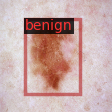

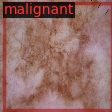

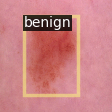

In [ ]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog
from google.colab.patches import cv2_imshow

dataset_dicts = DatasetCatalog.get("cancer_detection_train")   #get registered dataset

for d in random.sample(dataset_dicts, min(3, len(dataset_dicts))):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)  #convert the BGR channel to RBG
    out = visualizer.draw_dataset_dict(d)  #visualize using Detectron Visualizer
    cv2_imshow(out.get_image()[:, :, ::-1])  #again convert RGB to BGR for display


# Configure base model and define training parameters

In [ ]:
cfg = get_cfg()   #Load base configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # configure faster_rcnn_R_50_FPN_3x
cfg.DATASETS.TRAIN = ("cancer_detection_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # weights of pre-trained model
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 800   # for small dataset we used 800, maximum can be 27,000 for 3x
cfg.SOLVER.STEPS = []    # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # The "RoIHead batch size". 128 is faster, 256 is better of inferencing
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # classes: benign, malignant

# Setup Default Trainer and Start Training

In [ ]:
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)   #set output folder
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)  #False for training from scratch, True for training from a checkpoint.
trainer.train()

[05/06 19:09:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/06 19:09:40 d2.utils.events]:  eta: 0:04:27  iter: 19  total_loss: 0.2996  loss_cls: 0.07659  loss_box_reg: 0.2058  loss_rpn_cls: 0.0002395  loss_rpn_loc: 0.004077    time: 0.3796  last_time: 0.5253  data_time: 0.1075  last_data_time: 0.2013   lr: 2.4726e-06  max_mem: 1737M
[05/06 19:09:52 d2.utils.events]:  eta: 0:04:24  iter: 39  total_loss: 0.2783  loss_cls: 0.08495  loss_box_reg: 0.1772  loss_rpn_cls: 0.000135  loss_rpn_loc: 0.004104    time: 0.3869  last_time: 0.6052  data_time: 0.0921  last_data_time: 0.2839   lr: 4.9701e-06  max_mem: 1738M
[05/06 19:10:00 d2.utils.events]:  eta: 0:04:19  iter: 59  total_loss: 0.2783  loss_cls: 0.118  loss_box_reg: 0.154  loss_rpn_cls: 0.0006521  loss_rpn_loc: 0.005939    time: 0.3907  last_time: 0.5628  data_time: 0.1115  last_data_time: 0.2698   lr: 7.4676e-06  max_mem: 1738M
[05/06 19:10:09 d2.utils.events]:  eta: 0:04:15  iter: 79  total_loss: 0.2725  loss_cls: 0.08182  loss_box_reg: 0.1859  loss_rpn_cls: 0.0002064  loss_rpn_loc: 0.005301

# Define Default predictor using the trained model weights

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/06 19:20:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


# To Visualize all images in val

In [ ]:
# Load the full validation dataset
dataset_dicts = DatasetCatalog.get("cancer_detection_val")
benign_metadata = MetadataCatalog.get("cancer_detection_val")

# Loop through all entries in validation dataset
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1],
                   metadata=benign_metadata,
                   scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


# To check the precision of model

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("cancer_detection_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "cancer_detection_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[05/06 19:16:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/06 19:16:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/06 19:16:10 d2.data.datasets.coco]: Loaded 110 images in COCO format from /content/drive/MyDrive/Cancer_dataset/val.json
[05/06 19:16:10 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   benign   | 54           | malignant  | 56           |
|            |              |            |              |
|   total    | 110          |            |              |
[05/06 19:16:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/06 19:16:10 d2.data.common]: Serializing the dataset using: <class 'd